
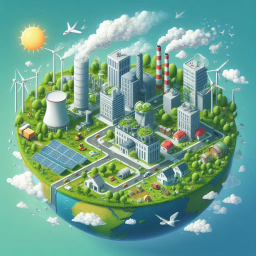 


# Proyecto ML-Machine learning:
## Responsabilidad Social Aragón Medioambiental RSA 2025
### Jose Luis Padilla Villanova     (Abril 2025)

#### 0. Importar librerias necesarias:

In [1]:
import sys
sys.path.append("../utils/")
import bootcampviztools as bt
import fitz  
import gower
import json
from opencage.geocoder import OpenCageGeocode
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import pandas as pd
import pickle # sirve para guardar cualquier objeto binario, inclusi el pipline
import re
import requests
import seaborn as sns
import sys
sys.path.append("../utils/")
import tensorflow_hub as hub
import time
import unicodedata
from PyPDF2 import PdfReader
from bs4 import BeautifulSoup
# from datetime import datetime
# import Toolbox as tb
# from Toolbox import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from itertools import combinations
from opencage.geocoder import OpenCageGeocode
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
# Asegurar que pandas muestra todo el contenido de las celdas
pd.set_option("display.max_colwidth", None)  # Muestra contenido completo en las celdas
pd.set_option("display.max_rows", None)  # Muestra todas las filas

#### 1. Problema de negocio

Una empresa especializada en asesoramiento empresarial medioambiental quiere disponer de un listado de potenciales clientes para su departamento de  marketing en su sede de Aragón.

La convocatoria anual del sello de Responsabilidad Social en Aragón de la edición 2025 es un reconocimiento para empresas en Aragón que publica datos de las entidades que lo han obtenido en su web de libre acceso. Ademas se dispone de un formulario rellenado por la empresa en el que recogen tanto sus datos de contacto como datos interesantes para determinar si la entidad puede ser una futura clienta de nuestros servicios.

Nos proponen basandonos en estas 1573 entidades y en la informacion aportada, detectar un grupo de entidades que encajen en el perfil entidad interesada en medioambiente y con necesidades de mejora para poder cubrir con nuestros servicios. 

#### 2. Problema técnico y cómo ayuda a resolver el problema de negocio.

Planteamos extraer los datos mas interesantes para la empresa de los formularios con web scraping usando beatifulsoup, realizaremos un tratamiento de los datos para realizar un analisis de agrupación jerárquica. 

La ventaja es que este analisis es interpretable y funciona bien con conjunto de datos pequeños. 

Trabajamos un problema de aprendizaje no supervisado, no disponemos de etiquetas de experiencia previa para comparar resultados. Agruparemos los datos, analizaremos los clusters obtenidos y elegiremos el más adecuado, pero será el departamento de marketing quien nos debe confirmar más tarde la validez de los resultados aportados con el exito de ventas sobre la lista aportada.

#### 3. Extracción de datos iniciales. Webscrapping(BeautiSoup) y requests

In [7]:
# Analizamos la pagina web de la que queremos extraer los datos:
url = "https://www.aragonempresa.com/empresas-sello-rsa/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "lxml")

In [ ]:
#Confirmamos conexión exitosa :
if response.status_code == 200:
    print("Conexión exitosa!")
else:
    print(f"Error: {response.status_code}")


Conexión exitosa!


##### 3.1 Inspección web

In [11]:
# Mostrar el contenido HTML de la página web en un formato más estructurado y legible. 
# Esto es especialmente útil para inspeccionar la estructura de la página y localizar las etiquetas y clases necesarias para extraer datos específicos.
# Vemos el HTML procesado con una indentación clara, lo cual facilita la identificación de elementos como , , o cualquier otra etiqueta en la página web.
# Como el contenido es demasiado largo para visualizarlo en la terminal, redirigirmos a un archivo de texto para analizarlo más cómodamente:

# Define la ruta y nombre del archivo en la carpeta deseada
ruta = "../utils/pagina_pretty.html"

with open(ruta, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print("Archivo guardado en:", ruta)



Archivo guardado en: ../utils/pagina_pretty.html


In [12]:
# Detectamos donde se alojan los datos que queremos extraer:
#<a href="imprimir.php?idusuario=987&amp;idencuesta=4" class="btn btn-default" target="_blank"><img src="../img/iconosanexos/icon_pdf.png" style="height:22px;">&nbsp;&nbsp;Cuestionario RSA - AUTONOMOS-AS</a>
# identificamos que se compone el documento pdf de cada entidad de la siguiente cadena:
# imprimir.php?idusuario=987&amp;idencuesta=4
# donde el numero 987 es el id de la empresa y el numero 4 es el id del cuestionario ya que hay 4 tipos de cuestionarios
# Por lo que podemos extraer los datos de cada empresa con el siguiente codigo:
for seccion in soup.find_all("a", href=True):
    if "imprimir.php" in seccion['href']:
        print(seccion['href'])

imprimir.php?idusuario=3125&idencuesta=4
imprimir.php?idusuario=1727&idencuesta=4
imprimir.php?idusuario=3541&idencuesta=4
imprimir.php?idusuario=1289&idencuesta=4
imprimir.php?idusuario=3192&idencuesta=4
imprimir.php?idusuario=1095&idencuesta=4
imprimir.php?idusuario=2759&idencuesta=4
imprimir.php?idusuario=696&idencuesta=4
imprimir.php?idusuario=2331&idencuesta=4
imprimir.php?idusuario=2119&idencuesta=4
imprimir.php?idusuario=536&idencuesta=4
imprimir.php?idusuario=2097&idencuesta=4
imprimir.php?idusuario=3234&idencuesta=4
imprimir.php?idusuario=1410&idencuesta=4
imprimir.php?idusuario=965&idencuesta=4
imprimir.php?idusuario=1754&idencuesta=4
imprimir.php?idusuario=1065&idencuesta=4
imprimir.php?idusuario=651&idencuesta=4
imprimir.php?idusuario=987&idencuesta=4
imprimir.php?idusuario=3446&idencuesta=4


In [15]:
# La pagina tiene un selector de paginas, por lo que podemos iterar sobre todas las paginas para extraer todos los datos:
# Tiene un estructura fija de 20 elementos por pagina, por lo que podemos iterar de 20 en 20 para extraer todos los datos
# Creamos una lista vacia para almacenar los datos de id de empresa y cuestionario para poder descargar los pdfs


lista_id = []

for i in range(0, 1580, 20):
    url = f"https://www.aragonempresa.com/empresas-sello-rsa/?start={i}&count=20"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    for seccion in soup.find_all("a", href=True):
        if "imprimir.php" in seccion['href']:
            match_usuario = re.search(r'idusuario=(\d+)&', seccion['href'])
            match_encuesta = re.search(r'idencuesta=(\d+)', seccion['href'])
            if match_usuario and match_encuesta:
                lista_id.append((match_usuario.group(1), match_encuesta.group(1)))

In [ ]:
# Tenemos una lista con id_cliente y id_formulario son 2 variables que se requieren para llamar
# a la direccion web particular de cada formulario de empresa para descargar el formulario pdf.
# Ordenamos por id_cliente
lista_id.sort()
# Ejemplo del primer elemento de nuestra lista
lista_id[0]

('1000', '7')

##### 3.2 Proceso de descarga de Formularios pdf, extracción datos y verificación (Ejecutar solo en local)
Se recomienda no ejecutar en Gibhub este apartado, porque genera archivos de mucho peso.
Dejo el codigo y las verificaciones de extracion de datos en los 4 tipo de formularios.
Generamos el dataframe de partida (df_0) que guardamos y podemos cargar

In [22]:
# Directorio donde guardarmos los PDFs formularios, es una carpeta que no subimos al repositorio por su tamaño.
carpeta_destino = r"..\data_ignore\EDA"

# nos aeguramos de que la carpeta de destino existe
os.makedirs(carpeta_destino, exist_ok=True)

for i, j in lista_id:
    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(carpeta_destino, f"empresa_sello_rsa_{i}_{j}.pdf")

    # Verificar si el archivo ya existe
    if not os.path.exists(ruta_archivo):
        pdf_url = f"https://www.aragonempresa.com/empresas-sello-rsa/imprimir.php?idusuario={i}&idencuesta={j}"
        response = requests.get(pdf_url)
        with open(ruta_archivo, "wb") as file:
            file.write(response.content)
        print(f"Descargado y guardado {ruta_archivo}")
    else:
        print(f"El archivo {ruta_archivo} ya existe, omitiendo descarga.")

Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1000_7.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1001_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1002_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1004_9.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1005_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1009_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1010_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1011_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1013_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1014_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1015_6.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_102_7.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1032_9.pdf
Descargado y guardado ..\data_ignore\EDA\empresa_sello_rsa_1036_6.pdf
Descargado y guardado

Analizando los formularios pdf descargados hemos detectado que hay 4 tipos de formularios.

Negocio considera las siguientes variables relevantes y que son comunes a los 4 con matices que tendremos que tener en cuenta a la hora de determinar los patrones:

| Variable                  | Tipo   |Descripción|
|---------------------------|--------|-|
|id_cliente| num | identificación del cliente|
|id_formulario| num.pdf | identifica los 4 tipos de formularios, revisar detecte correctamente los campos elegidos.|
| tipo_organizacion         | object |Autonomo (120), Pequeña empresa (850), Mediana empresa (124), Gran empresa (113), Empresa publica (18), Entidades(301), Ong(47) |
| nombre_organizacion       | object |Anonimizar, usaremos id_cliente|
| direccion                 | object |Convertir a latitud y longitus para geolocalizar en mapa|
| sector_actividad          | object |Analizar, variable importante para agrupar, esta en lenguaje natural, interesante relacionar con nivel de contaminación Más_contaminantes/Normal/Menos_contaminantes(sectores ecologicos, gestión residuos)|
| year    | object |Año comienzo actividad|
| persona_contacto          | object |Nombre de la persona responsable. Anonimizar, se usara en la fase de contacto comercial|
| email_contacto            | object |Email de contacto. Anonimizar, se usará en la fase de contacto comercial|
| pagina_web                | object |Anonimizar. Solo util para profundizar departamento comercial para adecuar oferta de servicios y conocer al cliente.|
| impacto_actividad         | object |Es lenguaje natural y recoge la valoración que da el cliente al impacto de su actividad en el medioambiente|
| prioridad mediambiental   | num |la entidad prioriza la importancia que le otorga a los siguientes aspectos para lograr el éxito, negocio solo se centra en la importancia que se la da a "Trabajar para proteger y mejorar el medio ambiente" en la gestión socialmente responsable. (1 más importante - 10 menos importante) Opciones:
|||Emplear prácticas empresariales abiertas y transparentes
|||Gestionar con ejemplaridad
|||Escuchar las necesidades y expectativas de sus grupos de interés
|||Poner en práctica medidas responsables en la gestión de Recursos Humanos
|||Ofrecer productos y servicios de calidad
|||Capacitación y desarrollo profesional
|||Disponer de presupuesto
|||Trabajar para proteger y mejorar el medio ambiente
|||Crear Programas con impacto positivo en la Comunicad Local
|||Ser un negocio rentable y sostenible en el tiempo|
| mejora                    | object |A la pregunta del cuestionario ¿Podría enunciar un área de mejora? Es lenguaje natural y Negocio considera interesante su estudio para detectar necesidades en las entidad, entendemos que si no hay mejoras es complicado aportar nuestros servicios|

PyMuPDF  es un módulo de Python que forma parte de la biblioteca PyMuPDF, la cual se utiliza para interactuar y trabajar con documentos PDF
Es especialmente útil para tareas relacionadas con la extracción, edición y manipulación de PDFs.

Y utilizamos la siguiente función para extraer los datos seleccionados, teniendo que encuenta que tenemos 4 formularios y hay que incluir diferentes alternativas.


In [23]:
def extraer_datos(pdf_path):
    datos = {}

    with fitz.open(pdf_path) as pdf:
        texto_completo = ""

        # Concatenar todo el texto de las páginas del PDF
        for page_num in range(len(pdf)):
            texto_completo += pdf[page_num].get_text()

        # Patrón para eliminar faldones de página (ej. "[...] página X/XX")
        patron_faldon = r'''\[-\d+\]# Número negativo entre corchetes
        \s*RSA\s-\s     # Literal "RSA -", seguido de espacios
        (Entidades\sno\slucrativas|GRANDES\sEMPRESAS\sY\sEMPRESAS\sPÚBLICAS|AUTONOMOS-AS|PYMES)?  # Opciones
        \s*página\s\d+/\d+\n?  # "página X/XX", opcionalmente con salto de línea final
        '''

        # Eliminar faldones del texto completo
        texto_sin_faldon = re.sub(patron_faldon, '', texto_completo, flags=re.VERBOSE | re.DOTALL)


        # ID del cliente y id_formulario
        datos["id_cliente"] = pdf_path.split("_")[-2]
        datos["id_formulario"] = pdf_path.split("_")[-1]

        # Tipo de organización
        patron_tipo = r"\n*RSA - (.*?)\n*Empresa evaluada"
        match_tipo = re.search(patron_tipo, texto_sin_faldon, re.DOTALL)
        if match_tipo:
            datos['tipo_organizacion'] = match_tipo.group(1).replace("\n", " ").strip()

        # Denominación de la organización
        patron_nombre = r"(\d{2} - )?Denominación de la organización\n(.*?)\n(02 - Dirección - CP - Población)?(Forma jurídica)?"
        match_nombre = re.search(patron_nombre, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_nombre:
            datos['nombre_organizacion'] = match_nombre.group(2).replace("\n", " ").strip()

        # Dirección
        patron_direccion = r"(\d{2} - )?Dirección - CP - Poblaci[oó]n\n(.*?)(\d{2} - )?Sector(. Actividad)?(/Ámbito de actuación.)?"
        match_direccion = re.search(patron_direccion, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_direccion:
            datos['direccion'] = match_direccion.group(2).replace("\n", " ").strip()

        # Sector y actividad principal
        patron_sector = r'\b(?:Sector(?:\. Actividad)?(?:/Ámbito de actuación\.)?|03 - Sector\. Actividad)\s*\n(.*?)(?=\n(?:Actividad principal|04 - Año comienzo actividad))'
        match_sector = re.search(patron_sector, texto_sin_faldon, re.DOTALL)
        if match_sector:
            datos['sector_actividad'] = match_sector.group(1).replace("\n", " ").strip()

        # Año de comienzo de actividad
        patron_year = r'(04 - )?Año comienzo actividad\.\n(.*?)\n(05 - Persona de contacto)?(05 - Número de personas empleadas)?(Número de personas empleadas - media anual)?'
        match_year = re.search(patron_year, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_year:
            datos['year'] = match_year.group(2).strip()  # Captura el año (2016)
        
        # Número de personas empleadas
        patron_empleados = (
            r'(05 - )?Número de personas empleadas( - media anual)?\n'  # Inicio del bloque
            r'(.*?)(?=(06 - Persona contacto|Número de personas empleadas estables \(contrato indefinido\)|$))'  # Capturar todo hasta antes del siguiente bloque o el final
            )
        # Buscar coincidencia
        match_empleados = re.search(patron_empleados, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_empleados:
            datos["empleados"] = match_empleados.group(3).strip()  # Captura todo el bloque intermedio

        # Persona de contacto
        patron_persona_contacto = r'\n(\d{2} - )?Persona (de )?contacto\n(.*?)\n(\d{2})?(E-mail contacto)?'
        match_persona_contacto = re.search(patron_persona_contacto, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_persona_contacto:
            datos['persona_contacto'] = match_persona_contacto.group(3).replace("\n", " ").strip()

        # E-mail de contacto
        patron_email_contacto = r'\n(\d{2} - )?e-mail (persona )?contacto:?\n(.*?)\n(\d{2}.- )?Página web'
        match_email_contacto = re.search(patron_email_contacto, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_email_contacto:
            datos['email_contacto'] = match_email_contacto.group(3).replace("\n", " ").strip()

        # Página web
        patron_pagina_web = r'\n(\d{2}.- )?Página web\n(.*?)\n*GENERAL'
        match_pagina_web = re.search(patron_pagina_web, texto_sin_faldon, re.DOTALL)
        if match_pagina_web:
            datos['pagina_web'] = match_pagina_web.group(2).replace("\n", " ").strip()

        # Impacto ambiental
        patron_impacto_actividad = r'(impacto )?ambiental en el desarrollo de la actividad\?\s*([\s\S]*?)\s*(?=Economía circular( y comunicación)?)'
        # Búsqueda en el texto
        match_impacto_actividad = re.search(patron_impacto_actividad, texto_sin_faldon, re.DOTALL)

        if match_impacto_actividad:
            datos["impacto_actividad"] = match_impacto_actividad.group(2).replace("\n", " ").strip()
    
        # Prioridad medioambiental
        patron_prioridad_medioambiental = r"(\d+) - Trabajar para proteger y mejorar el medio ambiente"
        match_prioridad_ma = re.search(patron_prioridad_medioambiental, texto_sin_faldon, re.DOTALL)
        if match_prioridad_ma:
            datos['prioridad mediambiental'] = match_prioridad_ma.group(1).strip()

        # Áreas de mejora
        patron_mejora = (
            r"\d+[.-]? ?-? ?¿Podría enunciar un [aá]rea de mejora\?\s*"
            r"((?:[^\n]*\n){1,20})"
            r"(?:\[-?\d+\] .*? página \d+/\d+\s*)?"
            r"\s*Agenda 2030 y Objetivos de Desarrollo Sostenible"
        )
        match_mejora = re.search(patron_mejora, texto_sin_faldon, re.DOTALL)
        if match_mejora:
            datos["mejora"] = " ".join(match_mejora.group(1).split())
    return datos


Realizamos una visualizacion individual de ejemplo en los 4 formatos de formulario para verificar que coge todos los campos correctamente:

In [24]:
pdf_path_4 = r"..\data_ignore\EDA\empresa_sello_rsa_1037_4.pdf"
datos_4 = extraer_datos(pdf_path_4)
df4 = pd.DataFrame([datos_4])   
print(df4.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           0
id_cliente                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [25]:
pdf_path_6 = r"..\data_ignore\EDA\empresa_sello_rsa_2505_6.pdf"
datos_6 = extraer_datos(pdf_path_6)
df6 = pd.DataFrame([datos_6])   
print(df6.T.to_string())

In [27]:
pdf_path_7 = r"..\data_ignore\EDA\empresa_sello_rsa_2448_7.pdf"
datos_7 = extraer_datos(pdf_path_7)
df7 = pd.DataFrame([datos_7])   
print(df7.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id_cliente                                                                                                                                                                                                                                                                                                                                                                                               

In [28]:
pdf_path_9 = r"..\data_ignore\EDA\empresa_sello_rsa_2608_9.pdf"
datos_9 = extraer_datos(pdf_path_9)
df9 = pd.DataFrame([datos_9])   
print(df9.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id_cliente                                                                                                                                                                                                                                                                                                                                                               

Para crear nuestro dataframe base creamos un diccionario previo 

In [29]:
diccionario_id = {usuario_id: encuesta_id for usuario_id, encuesta_id in lista_id}

In [ ]:
# Inicializar el DataFrame con las columnas adecuadas y aplicamos nuestra funcion extraer a 
# cada uno de los formulario pdf descargados:
df_base = pd.DataFrame()

keys = list(diccionario_id.keys())
values = list(diccionario_id.values())

for i in range(len(diccionario_id)):
    id_usuario = keys[i]
    id_formulario = values[i]
    pdf_path = f"..\\data_ignore\\EDA\\empresa_sello_rsa_{id_usuario}_{id_formulario}.pdf"
    datos = extraer_datos(pdf_path)
    df_base = pd.concat([df_base, pd.DataFrame([datos], index=[id_usuario])], ignore_index=False)

df_base.head()

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,pagina_web,impacto_actividad,prioridad mediambiental,mejora
1000,1000,7.pdf,GRANDES EMPRESAS Y EMPRESAS PÚBLICAS,EL CORTE INGLÉS S.A.,"C/Hermosilla, nº 112 28009 Madrid","Sector comercio, grandes almacenes",1941,81.714 personas,Isabel Paricio Perales,isabel_paricio@elcorteingles.es,www.elcorteingles.es,Se evalúa el impacto ambiental y se ha desarro...,2,Implantación de programas de comunicación global.
1001,1001,6.pdf,PYMES,"AYANET RRHH, S..L.","Calle Bari 57, Edificio TIC XXI (Plaza) 50.197...",Consultoría integral de Recursos Humanos: - Se...,1985,8,Tania Grande Maza,tgrande@ayanet.es,www.ayanet.es,Se evalúa el impacto ambiental y se llevan a c...,10,Quizá deberiamos trabajar algo más en materia ...
1002,1002,6.pdf,PYMES,"IMPROVING, CONSULTORIA Y FORMACION, S.L. (IMFO...","AVENIDA DE LA JACETANIA, 21, 22700 JACA HUESCA",FORMACION PARA EL EMPLEO,2010,7,ISABEL VITALLÉ ZAURIN,IVITALLE@EIMPROVING.ES,WWW.IMFORMA.ES,Se evalúa el impacto ambiental y se ha desarro...,4,Mejorar en materiales didácticos e indicadores...
1004,1004,9.pdf,Entidades no lucrativas,ACISJF IN VIA,"Paseo Echegaray y Caballero, 118, 50002 (Zarag...",Mujer/Acción Social,En Zaragoza en 1953,8,María Jesús Soler Cochi. Directora de Programas,acisjfzaragoza@gmail.com,www.acisjfzaragoza.org,Se evalúa el impacto ambiental y se llevan a c...,7,"Dar estabilidad al área económica, con proyect..."
1005,1005,6.pdf,PYMES,"ELECTRICIDAD AMARO, S.A.","Carretera del aeropuerto, km. 5,300 50.190 - Z...",Instalaciones eléctricas en general.,1982,4,Óscar Amaro Arceiz,oscar@eamaro.com,www.eamaro.com,Se tiene en cuenta el impacto ambiental ocasio...,6,Desarrollar más acciones sociales. Debemos mej...


In [32]:
# Guardamos el dataframe en un archivo csv en la carpeta data_sample
df_base.to_csv(r"..\data_sample\datos_rsa.csv")

##### 3.3 Cargamos nuestro archivo base guardado.

In [2]:
df_base = pd.read_csv("../data_sample/datos_rsa.csv")

#### 4. Limpieza de datos iniciales. 

Revisamos los datos del df_base para subsanar si es posible los faltantes, errores y proceso de anonimización 

In [3]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1573 non-null   int64  
 1   id_cliente               1573 non-null   int64  
 2   id_formulario            1573 non-null   object 
 3   tipo_organizacion        1573 non-null   object 
 4   nombre_organizacion      1573 non-null   object 
 5   direccion                1573 non-null   object 
 6   sector_actividad         1571 non-null   object 
 7   year                     1573 non-null   object 
 8   empleados                1457 non-null   object 
 9   persona_contacto         1544 non-null   object 
 10  email_contacto           1563 non-null   object 
 11  pagina_web               1568 non-null   object 
 12  impacto_actividad        1573 non-null   object 
 13  prioridad mediambiental  1568 non-null   float64
 14  mejora                  

| Variable                  | Tipo   |Descripción|Acción|
|---------------------------|--------|-|-|
|Unnamed:0|int|Automatico, duplicado id_cliente|Eliminar|
|id_cliente| num | identificación del cliente|Mantener, base para anonimizar|
|id_formulario| object | tipo formulario, solo sirve para imprimir |No aporta|
| tipo_organizacion         | object |Autonomo (120), Pequeña empresa (850), Mediana empresa (124), Gran empresa (113), Empresa publica (18), Entidades(301), Ong(47) |Mantener|
| nombre_organizacion       | object |Nombre cliente|Anonimizar, usaremos id_cliente|
| direccion                 | object |Direccion cliente|Convertir a latitud y longitus para geolocalizar en mapa|
| sector_actividad          | object |Sector actividad|Analizar, variable importante para agrupar, esta en lenguaje natural, interesante relacionar con nivel de contaminación Más_contaminantes/Normal/Menos_contaminantes(sectores ecologicos, gestión residuos)|
|year    | object |Año creación|No se considera interesante convertir a datatime, revisar porque puede haber diferentes formatos yyyy, dd/mm/yyyy....|
|empleados| object|Numero de empleados|En lenguaje natural, sera preciso revisar|
| persona_contacto          | object |Nombre de la persona responsable| Anonimizar, se usara en la fase de contacto comercial|
| email_contacto            | object |Email de contacto.| Anonimizar, se usará en la fase de contacto comercial|
| pagina_web                | object |web cliente|Anonimizar. Solo util para profundizar departamento comercial para adecuar oferta de servicios y conocer al cliente. falta alguna|
| impacto_actividad         | object |Es lenguaje natural y recoge la valoración que da el cliente al impacto de su actividad en el medioambiente|Contar palabras relevantes como indicativo de actividad relevante para el medioambiente, a mayor numero suponemos mas impacto medioambiental|
| prioridad mediambiental   | float |la entidad prioriza la importancia que le otorga a "Trabajar para proteger y mejorar el medio ambiente" en la gestión socialmente responsable. (1 más importante - 10 menos importante)| Convertir a int|
| mejora                    | object |A la pregunta del cuestionario ¿Podría enunciar un área de mejora? Es lenguaje natural y Negocio considera interesante su estudio para detectar necesidades en las entidad, entendemos que si no hay mejoras es complicado aportar nuestros servicios|Contar palabras relevantes como indicativo de necesidad de asesoria, suponemos que si no detecta la empresas areas de mejora es que esta poco abierta a contratar nuestros servicios.|

In [4]:
df_limpio = df_base.drop(columns="Unnamed: 0")

In [5]:
df_limpio["id_formulario"].value_counts()
# Esta variable no aporta informacion relevante para el analisis, 
# solo para visualizar fichas de empresa

id_formulario
6.pdf    975
9.pdf    348
7.pdf    134
4.pdf    116
Name: count, dtype: int64

<Axes: >

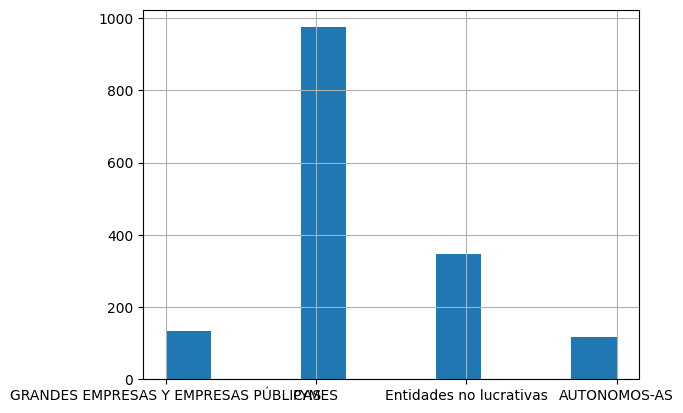

In [6]:
# Distribucion de los tipos de organizaciones
df_limpio["tipo_organizacion"].hist() # Distribucion de los tipos de organizaciones 

In [7]:
df_limpio["nombre_organizacion"].value_counts()

nombre_organizacion
Sin respuesta                                                                                   3
GRUPO ARAMARK                                                                                   2
CONNEXA SOSTENIBILIDAD Y DIGITALIZACIÓN S.L.                                                    2
EL CORTE INGLÉS S.A.                                                                            1
BARNIZADOS BARME S.L.                                                                           1
MINTAKELLER SL                                                                                  1
Calderería y Silos Metaga, S.L.                                                                 1
Exportadora Turolense S.L.                                                                      1
Nombre comercial: Mas la Llum                                                                   1
Cualimetal S.A.U,  ofrece diseño, fabricación y montaje propio, desde construcciones            1


In [8]:
#Detectamos 3 registros "Sin respuesta"
df_limpio[df_limpio["nombre_organizacion"] == "Sin respuesta"]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,pagina_web,impacto_actividad,prioridad mediambiental,mejora
425,1827,7.pdf,GRANDES EMPRESAS Y EMPRESAS PÚBLICAS,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 32.1. Información adicional Sin respuesta Compromiso frente al cambio climático 33.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta,NaN,Sin respuesta
956,3083,6.pdf,PYMES,Sin respuesta,CTRA. COGULLADA 8 50014-ZARAGOZA,DISTRIBUCION DE MATERIAL ELECCTRICO Y ELECTRONICO,1976,28,RAUL PINA,raulpina@elektraaragon.com,https://www.grupoelektra.es/es/el-grupo/empresa/elektra-aragon,"Se evalúa el impacto ambiental y se ha desarrollado un plan de acciones en materia ambiental global para toda la organización, que cuenta con objetivos e indicadores en seguimiento cuyo resultado se mide periódicamente. 29.1. Información adicional. Nuestra actividad tiene muy poco impacto medioambiental. Sin embargo estamos certificados con las ISO50001 y somos punto de recogida de luminarias, lámparas y equipos para su reciclaje Compromiso frente al cambio climático 30.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Existe un compromiso público junto con un plan de acciones que se comunica interna y externamente. 30.1. Información adicional. Damos soporte en eficiencia energética, vehículo eléctrico y renovables. Además de nuestro certificación en la ISO 50001",8.0,Tener un plan concreto con un presupuesto asignado para desarrollar nuestro RSC
1521,92,7.pdf,GRANDES EMPRESAS Y EMPRESAS PÚBLICAS,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 32.1. Información adicional Sin respuesta Compromiso frente al cambio climático 33.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta,NaN,Sin respuesta


In [9]:
# la linea 92 con formularios erroneos de la empresa 1827 formulario 6, por lo que los eliminamos:
indices_to_drop = [1521,425]
df_limpio.drop(index=indices_to_drop, inplace=True)
# la linea 3083 no tiene rellenado el nombre de organizacion pero viendo el formulario tenemos que es ELEKTRA ARAGÓN XXI, S.L. por lo que lo rellenamos manualmente:
df_limpio.loc[956, "nombre_organizacion"] = "ELEKTRA ARAGÓN XXI, S.L."

In [10]:
df_limpio[df_limpio["direccion"] == "Sin respuesta"]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,pagina_web,impacto_actividad,prioridad mediambiental,mejora
1512,905,6.pdf,PYMES,"ZEUMAT, SL",Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 29.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 30.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 30.1. Información adicional. Sin respuesta,NaN,Sin respuesta


In [11]:
# Cliente duplicado en la linea 905, el correcto es 911, 
df_limpio.drop(index=1512, inplace=True)

##### 4.1 Conversión dirección en coordenadas 

In [12]:
# Utilizamos opencage para localizar las coordenadas latitud y longitud de las direcciones 
# Definimos una función que primero revisa si ya tenemos las coordenadas en nuestro cuaderno json,
# si disponemos de coordinadas las coje del cuaderno en caso contrario acude a la API 
# si no hay dirección intenta con codigo postal y en ultimo caso nos indica los registro que
# bien no ha localizado o no tienen el codigo postal


#key = 'c8631658aa1d4f688649d97490bfdb23'
key = '868719c58b7843de8591665f0e53848f'
geocoder = OpenCageGeocode(key)

# Ruta del archivo donde guardar los resultados
cache_file = '../utils/geocoding_cache.json' 

def geocode_addresses(df, key, cache_file):
    geocoder = OpenCageGeocode(key)

    # Cargar caché existente
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            cache = json.load(f)
    else:
        cache = {}

    # Inicializar columnas de latitud y longitud
    df["latitud"] = None
    df["longitud"] = None

    for i in df_limpio.index:
        try:
            # Verificar si la dirección es válida
            query = str(df.loc[i, "direccion"])
            if pd.isnull(query) or query.strip() == "":
                print(f"Dirección vacía para id_cliente: {df.loc[i, 'id_cliente']}")
                continue

            # Verificar caché para la dirección completa
            if query in cache:
                df.at[i, "latitud"] = cache[query]["lat"]
                df.at[i, "longitud"] = cache[query]["lng"]
                continue

            # Realizar consulta a OpenCage
            results = geocoder.geocode(query)
            if results:
                lat = results[0]["geometry"]["lat"]
                lng = results[0]["geometry"]["lng"]
                df.at[i, "latitud"] = lat
                df.at[i, "longitud"] = lng
                cache[query] = {"lat": lat, "lng": lng}
                continue

            # Si no hay resultados, intentar con el código postal
            match = re.search(r"\b(50\d{3}|22\d{3}|44\d{3})\b", query)
            if match:
                postal_code = match.group(0)
                query_postal = f"{postal_code}, Spain"

                if query_postal in cache:
                    df.at[i, "latitud"] = cache[query_postal]["lat"]
                    df.at[i, "longitud"] = cache[query_postal]["lng"]
                else:
                    results_postal = geocoder.geocode(query_postal)
                    if results_postal:
                        lat = results_postal[0]["geometry"]["lat"]
                        lng = results_postal[0]["geometry"]["lng"]
                        df.at[i, "latitud"] = lat
                        df.at[i, "longitud"] = lng
                        cache[query_postal] = {"lat": lat, "lng": lng}
                    else:
                        print(f"No se encontraron coordenadas: {df.loc[i, 'id_cliente']} - {query_postal}")
            else:
                print(f"Dirección sin código postal: {df.loc[i, 'id_cliente']} - {query}")

            # Pausa entre consultas para evitar límites de velocidad
            time.sleep(1)

        except Exception as e:
            print(f"Error procesando id_cliente {df.loc[i, 'id_cliente']}: {e}")

    # Guardar caché actualizada
    with open(cache_file, "w") as f:
        json.dump(cache, f, indent=4)

    return df

In [13]:
df_limpio = geocode_addresses(df_limpio, key, cache_file) 
# direcciones no localizadas por falta de datos o errores en codigo postal
# como son 21 casos se busca manualmente y completaremos el cuaderno json con los codigos postales para simplificar

Dirección sin código postal: 1226 - Parque Científico Tecnológico Aula Dei. Polígono Valdeferrín, Edificio EXION. Locales 5 - 6
Dirección sin código postal: 1601 - Calle San Jorge, nº 7, pral.
Dirección sin código postal: 1645 - C/ Barrioverde, nº 10, local  y C/ Blanca de Navarra 2, local
Dirección sin código postal: 1674 - Plaza Cataluña oficinas
Dirección sin código postal: 1744 - CALLE DEL PARQUE, 2. 3º DCHA.
Dirección sin código postal: 2100 - CL JERONIMO ZURITA Nº17 ENTRESUELO DERECHA
Dirección sin código postal: 2209 - C/ 7 de febrero de 1882, num 2 local PIRINEUM
Dirección sin código postal: 2397 - PASEO ECHEGARAY Y CABALLERO 122, LOCAL
Dirección sin código postal: 253 - Calle Río Duero 13 Local
Dirección sin código postal: 2680 - Pol. Ind. Malpica, Calle D, Nº 65
Dirección sin código postal: 2683 - Paseo Constitución 43 bajo derecho
Dirección sin código postal: 2759 - As de Pisos  C/ San Ignacio de Loyola nº4 Local Zaragoza
Dirección sin código postal: 2831 - CALLE LA ENCINA N

In [14]:
# Diccionario con los id_cliente y sus códigos postales corregidos manualmente
codigos_postales_correcciones = {
    1226: "50600",
    1601: "50001",
    1645: "50010",
    1674: "50001",
    1744: "22002",
    2100: "50001",
    2209: "22700",
    2397: "50001",
    253: "50003",
    2680: "50016",
    2683: "50001",
    2759: "50008", 
    2831: "50171",
    3032: "50001",
    3087: "44600",
    494: "50009",
    585: "22197",
    623: "44556",
    840: "50001",
    943: "50014",
    952: "50001"
}

# Añadir manualmente los códigos postales al DataFrame
for id_cliente, codigo_postal in codigos_postales_correcciones.items():
    # Localizar la fila por el id_cliente y asignar el código postal manualmente
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "direccion"] = codigo_postal

# Verificar las filas actualizadas
print(df_limpio[df_limpio["id_cliente"].isin(codigos_postales_correcciones.keys())][["id_cliente", "direccion"]])


      id_cliente direccion
100         1226     50600
308         1601     50001
339         1645     50010
355         1674     50001
378         1744     22002
543         2100     50001
582         2209     22700
685         2397     50001
727          253     50003
765         2680     50016
768         2683     50001
813         2759     50008
850         2831     50171
925         3032     50001
959         3087     44600
1277         494     50009
1343         585     22197
1362         623     44556
1473         840     50001
1533         943     50014
1536         952     50001


In [15]:
# aplicamos de nuevo la funcion pra localizar las coordenadas de las 21 direcciones restantes
df_limpio = geocode_addresses(df_limpio, key, cache_file)

In [16]:
# Convertimos en float
df_limpio['long_num'] = pd.to_numeric(df_limpio['longitud'], errors='coerce').astype('float64')
df_limpio['latitud_num'] = pd.to_numeric(df_limpio['latitud'], errors='coerce').astype('float64')

In [17]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1454 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.2 Analisis de la variable: year 

Es una variable de lenguaje natural que se ha introducido com formato yyyy pero tambien con texto por lo que vamos a localizar el año, eliminar puntos tipo 1.989 para ello definimos una funcion que nos detecte el primer año de 4 digitos

In [18]:
df_limpio["year"].value_counts(dropna="False").sort_values(ascending=False)

year
2014                                                                                            43
2019                                                                                            42
2016                                                                                            39
2007                                                                                            36
2002                                                                                            33
2013                                                                                            33
2017                                                                                            32
2018                                                                                            32
2015                                                                                            31
1997                                                                                            31
2005 

In [19]:
# Función para detectar el primer año válido en diferentes formatos
# Función para limpiar puntos y extraer el primer año de 4 dígitos
def detectar_year(texto):
    if not texto or not isinstance(texto, str):  # Validar que el valor no sea nulo o no sea cadena
        return None
    # Quitar puntos de los números, como transformar "1.996" en "1996"
    texto_limpio = re.sub(r'(\d+)\.(\d+)', r'\1\2', texto)
    # Patrón para encontrar el primer año de 4 dígitos
    patron_year = r'\b(15\d{2}|16\d{2}|17\d{2}|18\d{2}|19\d{2}|20\d{2})\b'
    match = re.search(patron_year, texto_limpio)
    if match:
        return match.group(1)
    return None

In [20]:
# Aplicar la función al DataFrame y crear la nueva columna 'year_2'
df_limpio["year_2"] = df_limpio["year"].apply(detectar_year)

In [21]:
# Analizamos los valores unicos para detectar si hay nulos:
valores_unicos = df_limpio["year_2"].astype(str).unique()
valores_erroneos = [y for y in valores_unicos if not re.fullmatch(r"\d{4}", str(y))]
valores_unicos

array(['1941', '1985', '2010', '1953', '1982', '1999', '1910', '1990',
       'None', '2018', '1958', '1975', '2016', '1995', '2009', '1964',
       '1997', '1977', '1993', '1996', '2015', '2013', '1944', '1962',
       '2004', '1991', '2014', '1989', '2006', '2005', '2003', '2001',
       '1983', '2000', '2017', '2011', '1998', '2007', '1981', '2012',
       '1966', '1929', '2008', '1961', '1984', '1965', '1952', '1946',
       '2002', '1992', '1956', '1986', '1979', '1954', '1967', '1974',
       '1980', '1963', '1968', '1978', '1723', '1925', '1969', '1876',
       '1988', '1927', '1987', '1899', '1905', '2019', '1994', '1931',
       '1912', '1900', '1948', '1934', '2023', '1886', '1971', '1957',
       '2020', '1960', '1945', '1903', '1950', '1935', '1972', '1940',
       '2022', '1973', '1874', '1959', '1943', '1947', '2021', '1955',
       '1976', '1870', '1951', '1922', '1926', '1852', '1868', '1970',
       '1949', '2024', '1933', '1828', '1915', '1918', '1881', '1907',
      

In [22]:
# Filtrar las filas donde 'year_2' tiene valores nulos (None o NaN)
resultado = df_limpio[df_limpio["year_2"].isna()][["id_cliente", "year", "year_2"]]

# Mostrar el resultado
resultado

,id_cliente,year,year_2
9,1014,30/01/83,None
16,1051,HISTORIA,None
61,1156,"QUÍMICA DEL CINCA, S.L. es una empresa vinculada en el GRUPO SERUSAN,",None
103,1230,Nació como Asociación de Desarrollo Comunitario en Áreas de Aragón (ADCARA) el 24 de,None
186,136,T&Z Formación S.L. (System Zaragoza) inicia su actividad en Zaragoza en Septiembre de,None
205,1446,"Comenzó la actividad en la década de los 60, contamos con más de 50 años de",None
211,1457,La Sociedad Municipal Zaragoza Vivienda SLU. tiene su primer antecedente en el,None
256,1525,"La entidad tiene su origen bajo la denominación ASOCIACIÓN MANCALA, en Zaragoza,",None
303,1592,EL GRUPO EMPRESARIAL (INSTALACIONES LOPEZ) AL CUAL PERTENECE LA,None
357,169,Años de empresas anteriores:,None


In [23]:
# Creamos un diccionario manual con las correcciones de fechas de los 27 registros
fechas_correcciones = {1014: '1983',
 1051: '2005',
 1156: '1980',
 1230: '1994',
 136: '1996',
 1446: '1960',
 1457: '1960',
 1525: '1955',
 1592: '1976',
 169: '1998',
 1955: None,
 2391: '1990',
 2874: '1994',
 3236: '2014',
 3324: '2019',
 3338: '1994',
 3417: '1948',
 346: '2007',
 3522: '2020',
 465: '1969',
 542: '1975',
 548: '1992',
 660: '1962',
 696: None,
 960: '2000'}

# Añadir manualmente los códigos postales al DataFrame
for id_cliente, fecha in fechas_correcciones.items():
    # Localizar la fila por el id_cliente y asignar el código postal manualmente
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "year_2"] = fecha

# Verificar las filas actualizadas
print(df_limpio[df_limpio["id_cliente"].isin(fechas_correcciones.keys())][["id_cliente", "year_2"]])

      id_cliente year_2
9           1014   1983
16          1051   2005
61          1156   1980
103         1230   1994
186          136   1996
205         1446   1960
211         1457   1960
256         1525   1955
303         1592   1976
357          169   1998
513         1955   None
680         2391   1990
870         2874   1994
1052        3236   2014
1084        3324   2019
1085        3338   1994
1109        3417   1948
1141         346   2007
1189        3522   2020
1258         465   1969
1316         542   1975
1320         548   1992
1382         660   1962
1400         696   None
1543         960   2000


In [24]:
# Convertir valores no numéricos como "desconocido" en NaN para que sean ignorados al calcular la media
# Convertir valores no numéricos en NaN para calcular la media
df_limpio['year_2'] = pd.to_numeric(df_limpio['year_2'], errors='coerce')

# Calcular la media ignorando los NaN
media = df_limpio['year_2'].mean()

# Reemplazar "desconocido" o valores NaN por la media calculada
df_limpio['year_2'] = df_limpio['year_2'].fillna(media)

In [ ]:
# Convertir a int:
df_limpio['year_3'] = pd.to_numeric(df_limpio['year_2'], errors='coerce').astype('int')

In [26]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1454 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.3 Analisis de la variable: empleados 

Nos encontramos con valores numericos y texto, sera preciso convertir a numerico y revisar los errores

In [27]:
# Función para detectar trabajadores
def detectar_trabajadores(texto):
    if not texto or not isinstance(texto, str):  # Validar que el valor no sea nulo o no sea cadena
        return None
    # Quitar puntos de los números, como transformar "1.996" en "1996"
    texto_limpio = re.sub(r'(\d+)\.(\d+)', r'\1\2', texto)
    # Patrón para encontrar el primer numero
    patron_trabajadores = r'\b(\d+)\b'
    match = re.search(patron_trabajadores, texto_limpio)
    # if match:
    #     return match.group(1)
    # return None
    numeros_encontrados = re.findall(patron_trabajadores, texto_limpio)
    return numeros_encontrados

In [28]:
# Crear la columna 'empleados_2' si no existe
if 'empleados_2' not in df_limpio.columns:
    df_limpio['empleados_2'] = None

for i in range(len(df_limpio)):
    if df_limpio.iloc[i]["tipo_organizacion"] == "AUTONOMOS-AS":
        df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = 1
    else: 
        # Detectar el número de trabajadores usando la función y asignarlo a empleados_2
        trabajadores = detectar_trabajadores(df_limpio.iloc[i]["empleados"])
        if trabajadores:
            df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = trabajadores[0]
        else:
            df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = None

In [29]:
df_empleados_erroneos = df_limpio[df_limpio["empleados_2"].isnull()][["id_cliente", "empleados", "empleados_2"]]
df_empleados_erroneos

,id_cliente,empleados,empleados_2
9,1014,"Tres personas contratadas de continuo, subcontratacion según demanda de trabajo.",None
17,1054,EMPLEADAS : NINGUNA.\n.,None
69,1171,Dos personas de manera intermitente,None
133,1286,"Una persona empleada cotizando en régimen de artistas, se le contrata para las\nactuaciones, ensayos, etc. En ocasiones dos o tres personas contratadas, dependiendo de\nla necesidad de la producción.",None
161,1326,Seis,None
173,1343,"En estos momentos no existen personas empleadas directamente en la empresa, existen\ndiversos colaboradores habituales.",None
174,1344,"En la actualidad en nómina,solo tenemos un empleado",None
177,1348,Dos,None
183,1357,"Actualmente la Asociación cuenta con cinco trabajadoras; una trabajadora social, una\nmaestra en educación especial, una fisioterapeuta, una coordinadora y técnico\nadministrativo (persona con discapacidad física) y una psicóloga.",None
214,1461,EL PERSONAL ES VOLUNTARIO. ACTUALMENTE NO HAY EMPLEADOS,None


In [30]:
# Diccionario con los id_cliente y empleados corregidos manualmente, si no se aporta y no se valorara relevante se pone a 0
empleados_correcciones = {1014: '3',
 1054: '0',
 1171: '2',
 1286: '3',
 1326: '6',
 1343: '0',
 1344: '1',
 1348: '2',
 1357: '5',
 1461: '0',
 1462: '0',
 1495: '3',
 1586: '0',
 1644: '2',
 1658: '0',
 1729: '0',
 1779: '0',
 1782: '0',
 1840: '0',
 1864: '0',
 1884: '0',
 1907: '3',
 1919: '4',
 1923: '0',
 1951: '0',
 1952: '15',
 1971: '6',
 2126: '1',
 2129: '4',
 2233: '8',
 2291: '2',
 2315: '12',
 2392: '0',
 2678: '11',
 2703: '18',
 2706: '0',
 2708: '0',
 2820: '3',
 2915: '0',
 2921: '3',
 3007: '0',
 3050: '3',
 3068: '9',
 3087: '5',
 3107: '0',
 3111: '0',
 3114: '1',
 3151: '2',
 3157: '2',
 3158: '9',
 3165: '1',
 3201: '0',
 3230: '1',
 3256: '2',
 3396: '0',
 3411: '0',
 3429: '8',
 346: '14',
 3522: '5',
 461: '0',
 508: '0',
 559: '11',
 580: '20',
 639: '2',
 753: '0',
 906: '4',
 926: '5'}

# Añadir manualmente los empleados al DataFrame, la mayoria datos en letra
for id_cliente, empleados in empleados_correcciones.items():
    # Localizar la fila por el id_cliente y asignar el código postal manualmente
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "empleados_2"] = empleados

# Verificar las filas actualizadas
print(df_limpio[df_limpio["id_cliente"].isin(empleados_correcciones.keys())][["id_cliente", "empleados_2"]])

      id_cliente empleados_2
9           1014           3
17          1054           0
69          1171           2
133         1286           3
161         1326           6
173         1343           0
174         1344           1
177         1348           2
183         1357           5
214         1461           0
215         1462           0
238         1495           3
299         1586           0
338         1644           2
346         1658           0
369         1729           0
397         1779           0
401         1782           0
435         1840           0
451         1864           0
464         1884           0
480         1907           3
488         1919           4
491         1923           0
509         1951           0
510         1952          15
522         1971           6
549         2126           1
552         2129           4
597         2233           8
630         2291           2
643         2315          12
681         2392           0
764         26

In [31]:
# convertir en numero la columna empleados:
df_limpio['empleados_2'] = pd.to_numeric(df_limpio['empleados_2'], errors='coerce').astype('Int64')

In [32]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1454 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.4 Analisis de la variable: prioridad mediambiental

In [33]:
df_limpio["prioridad mediambiental"].value_counts().sort_values()
#Priorice la importancia que le otorga a los siguientes aspectos para lograr el éxito
#en la gestión socialmente responsable. (1 más importante - 10 menos importante)
# Trabajar para proteger y mejorar el medio ambiente

prioridad mediambiental
1.0      42
2.0      53
3.0      70
4.0     106
5.0     117
6.0     144
7.0     213
10.0    218
8.0     265
9.0     340
Name: count, dtype: int64

<Axes: >

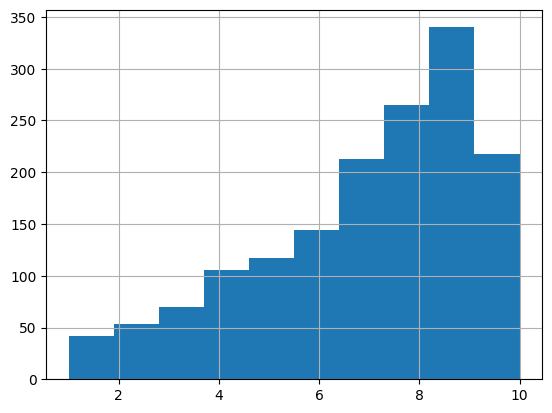

In [34]:
df_limpio["prioridad mediambiental"].hist()

In [35]:
df_limpio[df_limpio["prioridad mediambiental"].isnull()]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,impacto_actividad,prioridad mediambiental,mejora,latitud,longitud,long_num,latitud_num,year_2,year_3,empleados_2
508,1950,9.pdf,Entidades no lucrativas,Go Aragón,"Calle Dr. Horno Alcorta, 7, 50004 Zaragoza",Comunicación,2021,1,Alfredo Cortés Cubero,alfredo.cortes@goaragon.es,...,Sin respuesta 34.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 35.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 35.1. Información adicional. Sin respuesta,NaN,Sin respuesta,41.650238,-0.890085,-0.890085,41.650238,2021.000000,2021,1
913,3007,9.pdf,Entidades no lucrativas,ASOCIACIÓN DE FAMILIARES DE ENFERMOS DE ALZHEIMER Y OTRAS DEMENCIAS,"Calle Ciudad Deportiva Santa María, nº 6, bajos. 44600 Alcañiz",SERVICIOS SOCIALES Y ATENCIÓN SOCIOSANITARIA,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,...,Sin respuesta 34.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 35.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 35.1. Información adicional. Sin respuesta,NaN,Sin respuesta,41.05,-0.1333,-0.133300,41.050000,1996.014678,1996,0


In [36]:
# # asignamos prioridad moda a los que no han rellenado, consultaa realizada a negocio que valora encaja 
moda = df_limpio['prioridad mediambiental'].mode()[0]  # .mode() devuelve un objeto, tomamos el primer valor más frecuente

# # Reemplazar los valores nulos por la moda
# df_actualizado_3['prioridad mediambiental'].fillna(moda, inplace=True)

df_limpio['prioridad mediambiental'] = df_limpio['prioridad mediambiental'].fillna(moda)


In [37]:
df_limpio['prioridad_medioambiental'] = pd.to_numeric(df_limpio['prioridad mediambiental'], errors='coerce').astype('int')

In [38]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1568 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1454 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1559 non-null   object 
 14  latitud      

##### 4.5 Analisis de la variable: mejora

In [39]:
# Hay registro nulos, en estos casos vamos a marcarlo como "sin_mejora"
sin_mejora = "sin_mejora"
df_limpio.loc[:, 'mejora'] = df_limpio['mejora'].fillna(sin_mejora)

In [40]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1568 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1454 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1570 non-null   object 
 14  latitud      

##### 4.6 Analisis de la variable: sector actividad

In [41]:
# Localizar los nulos:
df_limpio[df_limpio["sector_actividad"].isnull()]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,prioridad mediambiental,mejora,latitud,longitud,long_num,latitud_num,year_2,year_3,empleados_2,prioridad_medioambiental
297,1584,9.pdf,Entidades no lucrativas,Feria de Zaragoza,"Autovía A II, Km. 311 50012 Zaragoza",NaN,1945,61,PILAR MARTÍN GUILLEN,mpmartin@feriazaragoza.es,...,8.0,Gestión medioambiental: Exigir a nuestros proveedores la mejora en su oferta respecto a este tema y poder guiarnos por esto y no por precio,41.6561,-0.8773,-0.8773,41.6561,1945.0,1945,61,8
722,2508,6.pdf,PYMES,ELECTRICIDAD MAYASA S.L.,"Polígono Miguel Servet, nave 3. 50013 Zaragoza",NaN,"En 1967, primero como persona física y más tarde como sociedad limitada.",24,Regina Martínez Gracia,regina.martinez@grupomayasa.com,...,6.0,Comunicar los objetivos planteados y los logrados.,41.6561,-0.8773,-0.8773,41.6561,1967.0,1967,24,6


In [42]:
# Diccionario con los id_cliente y sus sectores de actividad corregidos manualmente
codigos_sector_actividad = {
    1584: "Organización de convenciones y ferias de muestras.CNAE: 8230",
    2508: "Instalaciones eléctricas de BAJA TENSIÓN-- Instalaciones especiales- Revisión, reparación y bobinado de motores eléctricos. Construcción de cuadros (pequeñas y grandes series)- Gestión de energía reactiva- Suministro de materiales: consumo o grandes series.- Fabricación y trabajos en taller."
}

# Añadir manualmente los sectores de actividad al DataFrame
for id_cliente, sector in codigos_sector_actividad.items():
    # Localizar la fila por el id_cliente y asignar el código postal manualmente
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "sector_actividad"] = sector

# Verificar las filas actualizadas
print(df_limpio[df_limpio["id_cliente"].isin(codigos_sector_actividad.keys())][["id_cliente", "sector_actividad"]])

     id_cliente  \
297        1584   
722        2508   

                                                                                                                                                                                                                                                                                         sector_actividad  
297                                                                                                                                                                                                                                          Organización de convenciones y ferias de muestras.CNAE: 8230  
722  Instalaciones eléctricas de BAJA TENSIÓN-- Instalaciones especiales- Revisión, reparación y bobinado de motores eléctricos. Construcción de cuadros (pequeñas y grandes series)- Gestión de energía reactiva- Suministro de materiales: consumo o grandes series.- Fabricación y trabajos en taller.  


In [43]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1570 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1454 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1570 non-null   object 
 14  latitud      

#### 5. Tratamiento variables con lenguaje natural. 

Nos queda por tratar las variables con lenguaje natural.

Vamos a aplicarles procesos de tokenizacion y limpieza de caracteres superfluos.

En el caso de **"impacto_actividad"** valora Negocio que cuanto mayor sea el numero de palabras, mayor sera el impacto de la actividad en el medioambiente. 

Lo mismo sucede con **"mejora"** a mayor numero de palabras, mayor será el atractivo de la entidad para ofrecer nuestros servicios. 

Sin embargo con **"sector_actividad"** que tiene un alto grado de cardinalidad debido a que no hay un patrón claro que limite, hemos intentado distintos modelos de embedding sin resultado coherente. Se valora que es una variable relevante y por lo tanto se hace por negocio una clasificación manual de los sectores de actividad en 3 grupos:
    
    - Actividades contaminantes nivel alto (1)
    
    - Actividades contaminantes nivel medio (0)
    
    - Actividades contaminantes nivel baja (-1) tipo gestión residuos, mediambientales....





In [44]:
# Variable objeto a lenguaje natural a limpiar son:
variables_ln = ["sector_actividad", "impacto_actividad", "mejora"]

In [45]:
# Expresiones regulares para reemplazar caracteres
REPLACE_NO_SPACE = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile(r"(<br \s*/><br\s*/>)|(\-)|(\/)|(_)")

NO_SPACE = ""
SPACE = " "

# Función para eliminar acentos
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

# Función para limpiar texto
def clean(row):
    # Paso 1: Eliminar acentos
    row = remove_accents(row)

    # Paso 2: Excluir el patrón de CNAE seguido de números antes de limpiar
    match_cnae = re.findall(r'CNAE[:\s]*\d+', row)
    
    # Limpio signos y convierto a minúsculas
    dato = REPLACE_NO_SPACE.sub(NO_SPACE, row.lower())
    
    # Convierto retornos de carro y guiones en espacios
    dato = REPLACE_WITH_SPACE.sub(SPACE, dato)
    
    # Quito cualquier link
    dato = " ".join([word for word in dato.split() if "http" not in word])
    
    # Recupero "CNAE: ####" al texto limpio
    dato = " ".join(match_cnae + dato.split())
    
    return dato

In [46]:
for i in variables_ln:
    df_limpio[i+"_clean"] = df_limpio[i].apply(clean)

In [47]:
variables_ln_clean = ["sector_actividad_clean", "impacto_actividad_clean", "mejora_clean"]

In [48]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

In [49]:
dictionary = stopwords.words("spanish")

def remove_stopwords(row):
    # Expresión regular para detectar "CNAE" seguido de números
    pattern = r'CNAE \d+'
    
    # Divide las palabras y aplica la lógica
    dato = " ".join([word for word in row.split(" ") 
                     if word not in dictionary or re.match(pattern, word)])
    return dato

In [50]:
for i in variables_ln_clean:
    df_limpio[i+"_sin_stopwords"] = df_limpio[i].apply(remove_stopwords)

In [51]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1454 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [53]:
df_limpio[df_limpio["sector_actividad_clean_sin_stopwords"]==""]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,year_2,year_3,empleados_2,prioridad_medioambiental,sector_actividad_clean,impacto_actividad_clean,mejora_clean,sector_actividad_clean_sin_stopwords,impacto_actividad_clean_sin_stopwords,mejora_clean_sin_stopwords
618,2270,6.pdf,PYMES,Nuevas Tecnologías para el Desarrollo de Packaging y productos agroalimentarios con,"Polígono Industrial Empresarium, C/ Romero, 12, 50720 Zaragoza",2229,2010,43,Eva Gavin Nogués,egavin@tecnopackaging.com,...,2010.0,2010,43,8,,se evalua el impacto ambiental y se llevan a cabo acciones para segregar y reciclar residuos y para reducir el consumo de recursos naturales informacion adicional los proyectos de i+d de la empresa estan enfocados en su mayoria a la mejora de la sostenibilidad en todos los proyectos de la empresa se tiene en cuenta el impacto ambiental y en muchos de ellos se realizan estudios de impacto ambiental la empresa ha elaborado una memoria para acceder al sello de economia circular del gobierno de aragon para ello se han establecido unos indicadores y objetivos ambientales y se llevara a cabo un seguimiento periodico de los mismos compromiso frente al cambio climatico ¿se participa o se ponen en marcha acciones que evidencien el compromiso publico de la organizacion para prevenir la contaminacion se ha participado en alguna iniciativa de forma puntual informacion adicional todas las lineas de investigacion de la empresa estan enfocadas a la reutilizacion reciclado y o biodegradacion de materiales tanto de la empresa como de sus clientes los resultados de los proyectos se comunican aunque no de manera planificada y formal,desarrollo de un plan de accion con objetivos medibles,,evalua impacto ambiental llevan cabo acciones segregar reciclar residuos reducir consumo recursos naturales informacion adicional proyectos i+d empresa estan enfocados mayoria mejora sostenibilidad proyectos empresa cuenta impacto ambiental realizan estudios impacto ambiental empresa elaborado memoria acceder sello economia circular gobierno aragon ello establecido indicadores objetivos ambientales llevara cabo seguimiento periodico mismos compromiso frente cambio climatico ¿se participa ponen marcha acciones evidencien compromiso publico organizacion prevenir contaminacion participado alguna iniciativa forma puntual informacion adicional todas lineas investigacion empresa estan enfocadas reutilizacion reciclado biodegradacion materiales empresa clientes resultados proyectos comunican aunque manera planificada formal,desarrollo plan accion objetivos medibles


In [54]:
df_limpio.loc[df_limpio["sector_actividad_clean_sin_stopwords"]=="","sector_actividad_clean_sin_stopwords"]="fabricacion productos plastico"

In [57]:
df_limpio["impacto_recuento"] = df_limpio["impacto_actividad_clean_sin_stopwords"].apply(lambda x: len(x.split()))
df_limpio["mejora_recuento"] = df_limpio["mejora_clean_sin_stopwords"].apply(lambda x: len(x.split()))

In [58]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1454 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [ ]:
# Obtener valores únicos de la columna

actividades = df_limpio["sector_actividad_clean_sin_stopwords"].value_counts()

In [71]:
df_actividades = actividades.reset_index()
df_actividades.columns = ['sector_actividad', 'count']


In [72]:
# Guardamos el dataframe en un archivo csv en la carpeta data_sample para facilitar rellenado en excel:
df_actividades.to_csv(r"..\data_sample\datos_actividades.csv", index=True)

In [73]:
# Llamamos al excel rellenado manualmente:
df_actividades_manual = pd.read_excel(r"..\data_sample\clasificacion.xlsx", usecols=["sector_actividad", "clasificacion_manual"])

In [74]:
# Crear un diccionario de clasificaciones desde df_actividades_manual
diccionario_clasificaciones = dict(zip(df_actividades_manual['sector_actividad'], df_actividades_manual['clasificacion_manual']))

# Añadir la clasificación al df_limpio utilizando map
df_limpio['clasificacion'] = df_limpio['sector_actividad_clean_sin_stopwords'].map(diccionario_clasificaciones)


In [75]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1454 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [77]:
df_clasificado = df_limpio[["id_cliente", "tipo_organizacion","year_3", "empleados_2", "prioridad_medioambiental", "latitud_num", "long_num", "impacto_recuento", "mejora_recuento", "clasificacion" ]]
df_clasificado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   tipo_organizacion         1570 non-null   object 
 2   year_3                    1570 non-null   int32  
 3   empleados_2               1570 non-null   Int64  
 4   prioridad_medioambiental  1570 non-null   int32  
 5   latitud_num               1570 non-null   float64
 6   long_num                  1570 non-null   float64
 7   impacto_recuento          1570 non-null   int64  
 8   mejora_recuento           1570 non-null   int64  
 9   clasificacion             1570 non-null   int64  
dtypes: Int64(1), float64(2), int32(2), int64(4), object(1)
memory usage: 156.5+ KB


#### 6. miniEDA 

El objetivo del miniEDA:

1. Necesitamos ver si hay que escalar (y transformasr) las features numéricas, porque los algoritmos de agrupamiento o clustering utilizan distancias y, por tanto, son sensibles al escalado.
2. Necesitamos codificar las variables categóricas que vayamos a usar y ver cómo eso afecta al escalado anterior.
 


In [80]:
def describe_df(df_origen):
    '''La función recibe un dataframe origen y devuelve un dataframe resultado 
    con información sobre el tipo de dato, valores faltantes, valores únicos y cardinalidad
    
    Argumento: 
    1. Parámetro único: DataFrame a analizar

    Retorna:
    1. Nombre de la variable
    2. Tipo de dato de la variable
    3. Porcentaje de valores nulos de la variable
    4. Número de valores únicos de la variable
    5. Porcentaje de cardinalidad de la variable


    '''
    # Creamos el diccionario para almacenar los resultados de los indicadores:
    resultado = {
        "COL_N": [],
        "DATA_TYPE": [],
        "MISSINGS (%)": [],
        "UNIQUE_VALUES":[],
        "CARDIN (%)": []
    }
    # Rellenamos los valores iterando en las columnas del DataFrame de origen:
    for col in df_origen.columns:
        resultado["COL_N"].append(col)
        resultado["DATA_TYPE"].append(df_origen[col].dtype)
        missings = round(df_origen[col].isna().sum()/len(df_origen)*100, 1)
        resultado["MISSINGS (%)"].append(missings)
        valores_unicos=df_origen[col].nunique()
        resultado["UNIQUE_VALUES"].append(valores_unicos)
        cardinalidad = round((valores_unicos/len(df_origen))*(1-missings/100),2)
        resultado["CARDIN (%)"].append(cardinalidad)
    
    df_resultado = pd.DataFrame(resultado) # convertimos en un DataFrame

    df_resultado.set_index("COL_N", inplace=True) # Establecemos como indices los nombres de las variables


    return df_resultado.T #Trasponemos el DataFrame

In [82]:
describe_df(df_clasificado).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
id_cliente,int64,0.0,1570,1.0
tipo_organizacion,object,0.0,4,0.0
year_3,int32,0.0,118,0.08
empleados_2,Int64,0.0,236,0.15
prioridad_medioambiental,int32,0.0,10,0.01
latitud_num,float64,0.0,769,0.49
long_num,float64,0.0,768,0.49
impacto_recuento,int64,0.0,312,0.2
mejora_recuento,int64,0.0,93,0.06


| Variable                  | Tipo   |Descripción|
|---------------------------|--------|-|
|id_cliente                 | int    |Numero de entidad(1570 entidades)| 
|tipo_organizacion         | object | 4 tipos de entidades (autonomos,gran empresa, publicas, entidades no lucrativas) |
| year_3    | int |Año de creacion de la entidad|
| empleados_2          | int |Numero de empleados|
| prioridad mediambiental   | int | Escala de 1 a 10 la importancia que le da a medioambiente, tal vez reducir a 3 para mejorar la interpretacion de resultados|
|latitud_num y long_num| float| coordenadas de la direccion|
| impacto_recuento        | int |312 valores, mas valor mas impacto medioambiental|
| mejora_recuento                    | int |93 valores, mas valor mas interesante el cliente|
| clasificacion          | int |1,0,-1 (Muy contaminante, Medio, Bajo contaminante)|

In [84]:
df_clasificado.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,1570.0,1919.57707,974.397077,86.0,1073.25,1838.5,2808.75,3582.0
year_3,1570.0,1996.01465,29.495964,1542.0,1989.0,2002.0,2013.0,2024.0
empleados_2,1570.0,331.787261,3956.129261,0.0,3.0,12.0,43.75,104000.0
prioridad_medioambiental,1570.0,7.070064,2.409654,1.0,6.0,8.0,9.0,10.0
latitud_num,1570.0,39.878225,8.38791,-36.798193,41.555,41.6561,41.681604,57.824236
long_num,1570.0,-7.350071,30.574674,-171.233,-1.027775,-0.8773,-0.78984,126.22865
impacto_recuento,1570.0,115.720382,103.18525,6.0,63.0,88.0,136.0,1896.0
mejora_recuento,1570.0,17.133758,17.263635,1.0,6.0,11.5,22.0,122.0
clasificacion,1570.0,0.349682,0.534963,-1.0,0.0,0.0,1.0,1.0


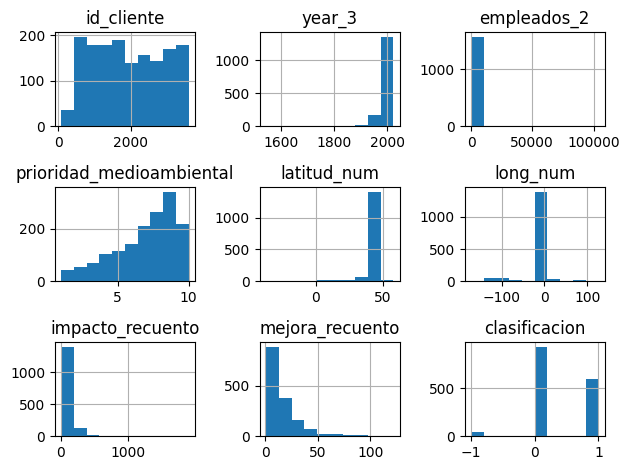

In [85]:
df_clasificado.hist()
plt.tight_layout()

Aplicamos el escalado consultando con negocio que nos indica que como todas las entidades se situan en Aragón se desecha clasificar por coordenadas

In [ ]:
# Prioridad medioambiental reducimos de 10 a 2 tipos
def mapping_prioridad(x):
    if x > 5:
        return 1 # Entidades que tienen en su top 5 la prioridad mediambiental
    else:
        return 0 # Entidades que no lo considerar en su top 5

df_clasificado.loc[:, 'prioridad_medioambiental_map'] = df_clasificado['prioridad_medioambiental'].apply(mapping_prioridad)


In [ ]:
# Normalizamos la variable year la reducimos a 4 escalas para simplificar 
def mapping_year(x):
    if pd.isna(x):
        return 3  
    elif x > 2020:
        return 3 
    elif x > 2000:
        return 2
    elif x > 1980: 
        return 1
    else:
        return 0

df_clasificado.loc[:, 'year_map'] = df_clasificado['year_3'].apply(mapping_year)

In [ ]:
# Normalizamos la variable empleados:
def mapping_empleados(x):
    if pd.isna(x):
        return 0  
    elif x > 150:
        return 3
    elif x > 50:
        return 2
    elif x > 15:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'empleados_map'] = df_clasificado['empleados_2'].apply(mapping_empleados)

In [ ]:
# Normalizamos impacto con el umbral en 150 palabras

def mapping_impacto(x):
    if x > 150:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'impacto_recuento_map'] = df_clasificado['impacto_recuento'].apply(mapping_impacto)

In [ ]:
# Normalizamos mejora con el umbral en 25 palabras

def mapping_mejora(x):
    if x > 25:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'mejora_recuento_map'] = df_clasificado['mejora_recuento'].apply(mapping_mejora)

In [116]:
#  Nuestras variables finales:

features_cat = ["tipo_organizacion", "prioridad_medioambiental_map", "clasificacion"]
features_num = ["year_map", "empleados_map","impacto_recuento_map", "mejora_recuento_map"]

Text(0.5, 1.0, 'Variable categórica')

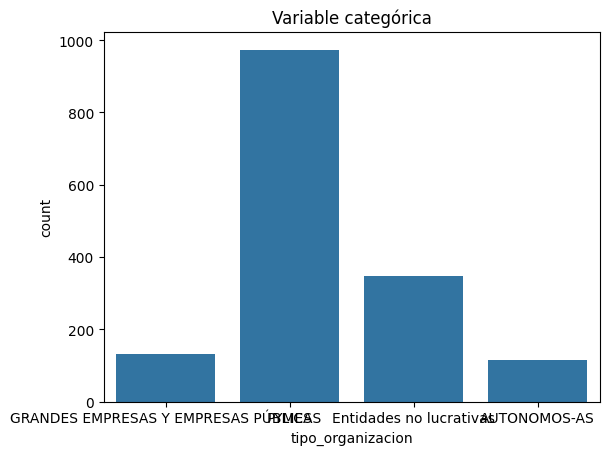

In [104]:
sns.countplot(data=df_clasificado, x="tipo_organizacion")
plt.title("Variable categórica")

Text(0.5, 1.0, 'Variable categórica')

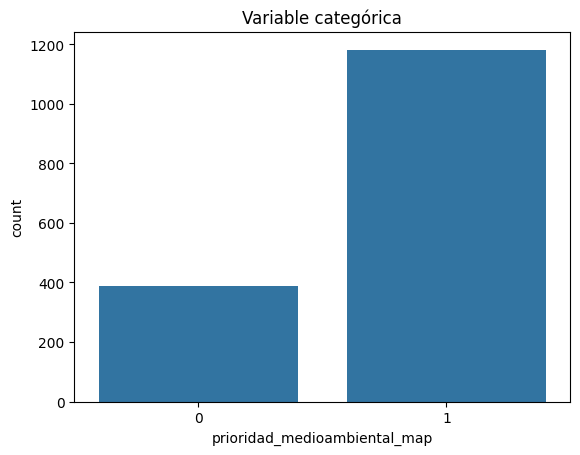

In [105]:
sns.countplot(data=df_clasificado, x="prioridad_medioambiental_map")
plt.title("Variable categórica")

Text(0.5, 1.0, 'Variable categórica')

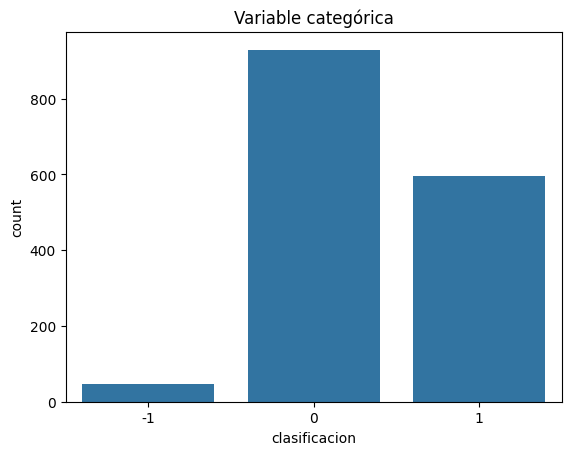

In [106]:
sns.countplot(data=df_clasificado, x="clasificacion")
plt.title("Variable categórica")

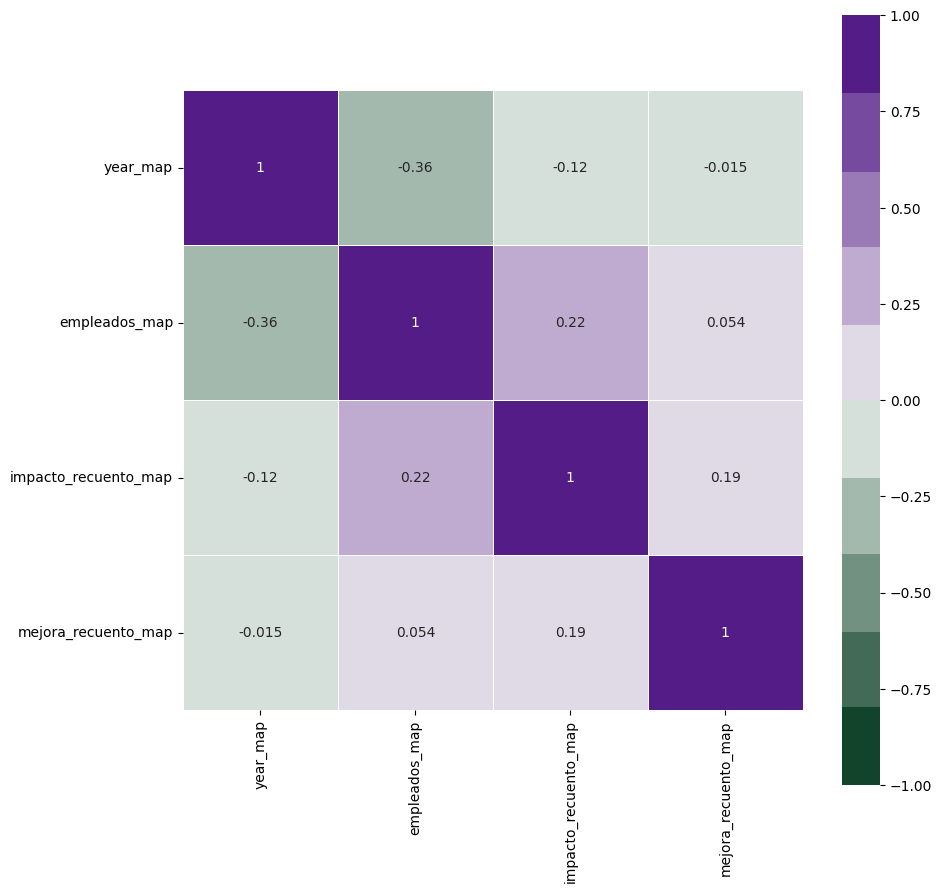

In [111]:
# Establece los límites de colores entre [-1, 1], así como un rango de colores de oscuro a oscuro, pasando por claro (0 correlación)
plt.figure(figsize=(10,10))
sns.heatmap(df_clasificado[features_num].corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

#### 7. Arquitectura de la solución 

In [113]:
train_set = df_clasificado[features_cat+features_num]

La distancia de Gower es útil cuando trabajas con conjuntos de datos que incluyen diferentes tipos de variables, como categóricas, numéricas y ordinales. A diferencia de otras métricas de distancia (como la euclidiana o manhattan), Gower está diseñado para manejar este tipo de datos heterogéneos de manera eficaz

In [ ]:
# Calcular la matriz de Gower

gower_matrix = gower.gower_matrix(train_set)

C:\Users\josel\AppData\Local\Temp\ipykernel_20028\2386712288.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(gower_matrix, method='average')


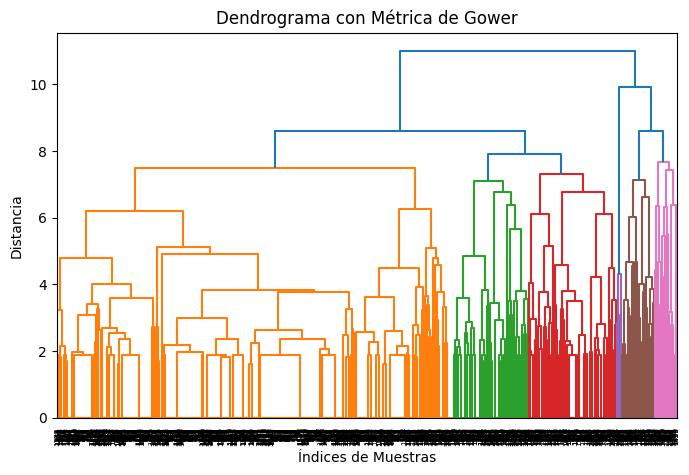

In [115]:
# Generar el enlace jerárquico utilizando la matriz de Gower
linked = linkage(gower_matrix, method='average')

# Crear el dendrograma
plt.figure(figsize=(8, 5))
dendrogram(linked, labels=train_set.index.tolist(), distance_sort='ascending')
plt.title("Dendrograma con Métrica de Gower")
plt.xlabel("Índices de Muestras")
plt.ylabel("Distancia")
plt.show()

Tenemos 6 clusters identificados por el modelo el siguiente paso sera elegir el mas adecuado para Negocio

In [118]:
# Clustering jerárquico basado en la matriz de distancia de Gower
clusters = linkage(gower_matrix, method='complete')

# Obtener las etiquetas de los clusters 
labels = fcluster(clusters, t=6, criterion='maxclust')

train_set.loc[:, 'Cluster'] = labels


C:\Users\josel\AppData\Local\Temp\ipykernel_20028\2221690740.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(gower_matrix, method='complete')


In [119]:
train_set["Cluster"].value_counts()

Cluster
3    739
4    538
5    126
6    107
2     33
1     27
Name: count, dtype: int64

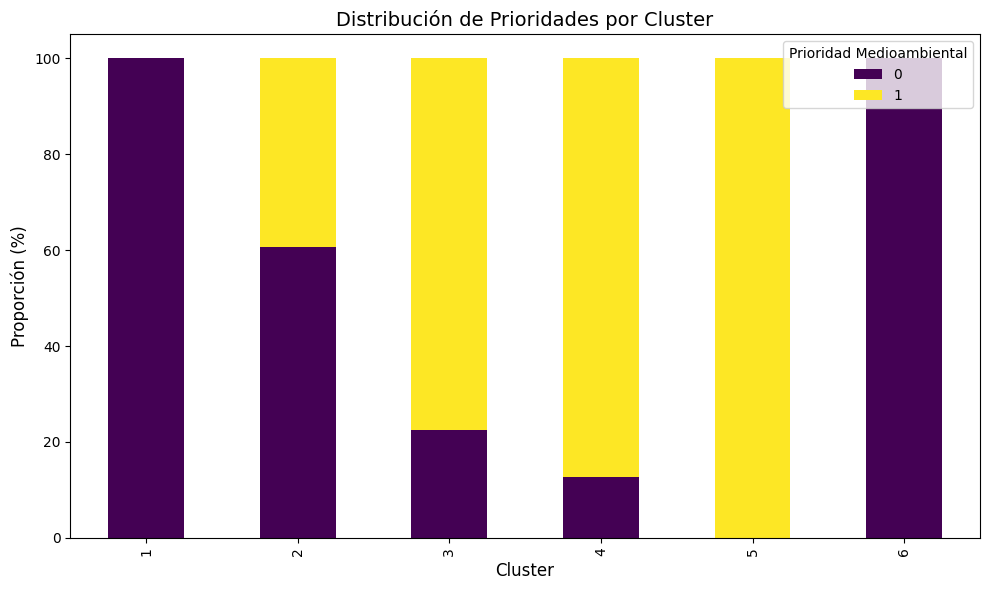

In [132]:
ax = prioridad_por_cluster.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
ax.set_title('Distribución de Prioridades por Cluster', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Proporción (%)', fontsize=12)
ax.legend(title='Prioridad Medioambiental', loc='upper right')
plt.tight_layout()
plt.show()


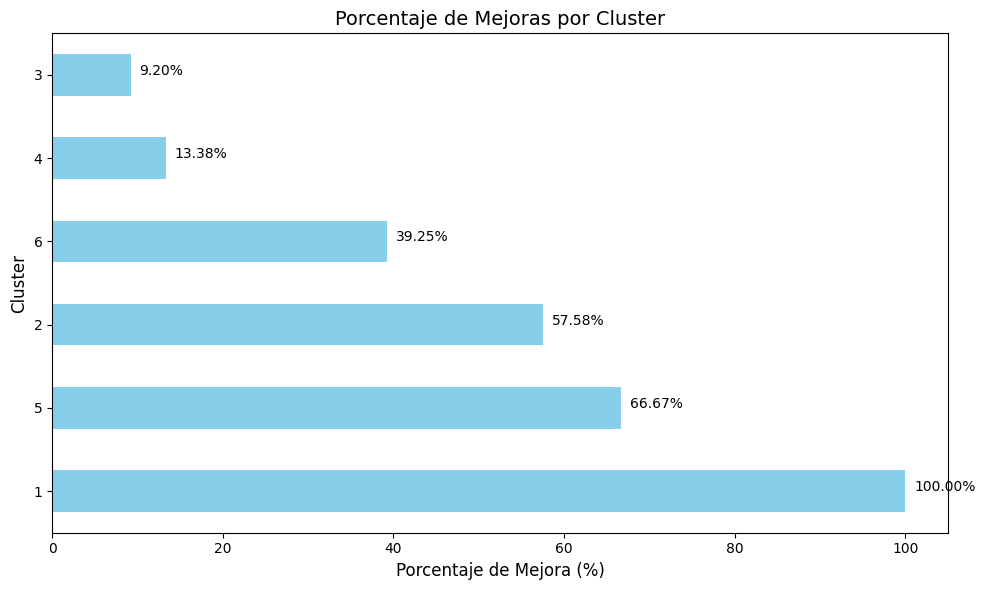

In [130]:
ax = mejoras_por_cluster.sort_values(ascending=False).plot(kind='barh', color='skyblue', figsize=(10, 6))
ax.set_title('Porcentaje de Mejoras por Cluster', fontsize=14)
ax.set_xlabel('Porcentaje de Mejora (%)', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
for i, value in enumerate(mejoras_por_cluster.sort_values(ascending=False)):
    ax.text(value + 1, i, f'{value:.2f}%', fontsize=10, color='black')
plt.tight_layout()
plt.show()


Proponemos a Negocio nuestro cluster 5 porque son entidades que tienen el medioambiente en el top 5 de sus prioridades y tienen claro interes de mejoras ya que un 66.67 % de las entidades de este grupo en su formulario han superado el umbral de 25 palabras.

Procederemos a enviar a Negocio la lista de las 126 entidades con sus datos de contacto para el departamento de marketing.

In [138]:
df_cluster = pd.concat([train_set[["Cluster"]],
                            df_clasificado[["id_cliente"]]], axis=1)

In [158]:
df_cluster_5 = df_cluster[df_cluster["Cluster"]==5]
len(df_cluster_5)


126

In [159]:
merged_df = pd.merge(df_cluster_5, df_limpio, on='id_cliente', how='left')
merged_df.sample().T


,77
Cluster,5
id_cliente,3504
id_formulario,9.pdf
tipo_organizacion,Entidades no lucrativas
nombre_organizacion,ASOCIACION ARAGONESA DE PSICOPEDAGOGIA
direccion,"PASEO DE LA CONSTITUCION 19, PLANTA 6ª CP: 50008 ZARAGOZA"
sector_actividad,ÁMBITO EDUCATIVO
year,La Asociación comenzó en 1994.
empleados,Las personas empleadas a tiempo completo son 3 en Secretaría Técnica.
persona_contacto,"Natalia Solá Tobillas, Secretaría Técnica."


#### 8. Ampliación a supervisado

Una vez validado nuestro cluster por Negocio se nos plantea aprovechar esta informacion para crear un modelo que basandose en los datos externos de las empresas podamos inferir si tienen prioridad medioambiental. En estos caso no contamos con encuestas de ningun tipo.

En este caso plateamos un modelo que basandose en las variables tipo organizacion, clasifición de actividad, año de creación, empleados nos prediga que encaja en nuestro cluster objetivo.

Puede ser una herramienta util para marketing seleccionar empresas. 

In [ ]:
# Seleccionamos las variables externas sin mapeo:

df_supervisado = pd.concat([train_set[["tipo_organizacion", "clasificacion", "Cluster"]],
                            df_clasificado[["year_3", "empleados_2"]]], axis=1)

In [166]:
# Simplificamos a nuestro clauster objetivo

def mapping_cluster(x):
    if x == 5:
        return 1 # Si es del cluster 5
    else:
        return 0

df_supervisado.loc[:, 'cluster_obj'] = df_supervisado['Cluster'].apply(mapping_cluster)

In [167]:
df_supervisado = df_supervisado.drop(columns= "Cluster")

In [168]:
train, test = train_test_split(df_supervisado, test_size=0.2, random_state=42)

In [169]:
# Definición del problema de clasificación.

# target_clf → Variable objetivo para clasificación.
#    - Se ha definido previamente como "cluster_obj".
#    - 1 si esta en nuestra cluster 5, 0 en caso contrario.
#    - Es un problema de clasificación **binario** (2 categorías posibles).

target_clf = "cluster_obj"

y_train_cat = train["cluster_obj"]
y_test_cat = test["cluster_obj"]

In [170]:
# Definición de las características (features) utilizadas en la clasificación:

# features_cat_clf → Variables categóricas
#    - Contiene solo la variable "tipo_organizacion" ().
#    - Se debe transformar con OneHotEncoder para convertirla en variables numéricas.

# features_num_clf_1 → Variables numéricas
#    - clasificacion ya esta normalizada: 1 contaminante 0 media -1 ecologica
# features_num_clf_2 
#    - year_3 le aplicaremos ordinal_encoding y la consideraremos como categorica
#    - empleados_2 le aplicaremos orinal encoding y se considera categorica   


features_cat_clf = ["tipo_organizacion","clasificacion"]
features_num_clf = ["year_3", "empleados_2"]

In [171]:
# Definición de columnas a incluir y excluir en el modelo de clasificación.

# columns_to_keep_clf → Columnas que se mantendrán en el modelo de clasificación.
#    - Incluye:
#      - features_num_clf_1 (variables numéricas relevantes).
#      - features_cat_clf (variables categóricas a transformar con OneHotEncoder).

# columns_to_exclude_clf → Columnas que se excluirán del modelo de clasificación.
#    - Se obtienen eliminando de df.columns las variables incluidas en columns_to_keep_clf.
#    - Estas columnas no serán utilizadas en el modelo.

columns_to_keep_clf =  features_num_clf + features_cat_clf

columns_to_exclude_clf = [col for col in train.columns if col not in columns_to_keep_clf] 

columns_to_exclude_clf

['cluster_obj']

In [172]:
# Definición de Pipelines para preprocesamiento de datos en clasificación.

# cat_pipeline → Preprocesamiento de variables categóricas.
#    - "Impute_Mode": Imputa valores faltantes con la moda (valor más frecuente).
#    - "OHEncoder": Aplica OneHotEncoder, ignorando categorías desconocidas, en lugar generar un error

# logaritmica → Transformación logarítmica de variables numéricas.
#    - Usa FunctionTransformer con np.log1p para estabilizar distribuciones sesgadas.
#    - feature_names_out="one-to-one" mantiene los nombres originales de las características.

# num_pipeline → Preprocesamiento de variables numéricas.
#    - "Impute_Mean": Imputa valores faltantes con la media.
#    - "logaritmo": Aplica la transformación logarítmica definida antes.
#    - "SScaler": Aplica StandardScaler para normalizar las variables numéricas.

# imputer_step_cat → ColumnTransformer para aplicar los Pipelines según el tipo de variable.
#    - "Process_Numeric": Aplica num_pipeline a features_num_clf_1 (variables numéricas).
#    - "Process_Categorical": Aplica cat_pipeline a features_cat_clf (variables categóricas).
#    - "Exclude": Elimina las columnas en columns_to_exclude_clf.
#    - remainder="passthrough": Mantiene cualquier otra columna sin modificar.

# pipe_missings_cat → Pipeline final que aplica el ColumnTransformer imputer_step_cat.

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy="most_frequent")), 
     ("OHEncoder", OneHotEncoder(handle_unknown='ignore'))  
    ]
)
logaritmica = FunctionTransformer(np.log1p, feature_names_out="one-to-one") 
# Convierte las funciones a transformadores
# mapping_empleados_transformer = FunctionTransformer(mapping_empleados)
# mapping_year_transformer = FunctionTransformer(mapping_year)

num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")), 
     ("logaritmo", logaritmica),
     ("SScaler", StandardScaler()),
    ]
)

imputer_step_cat = ColumnTransformer(
    [("Process_Numeric", num_pipeline,features_num_clf),
     ("Process_Categorical", cat_pipeline, features_cat_clf), 
     ("Exclude", "drop", columns_to_exclude_clf)],
       remainder = "passthrough"
    )

pipe_missings_cat = Pipeline([("first_stage", imputer_step_cat)])

In [173]:
# Definición de Pipelines para modelos de clasificación.
#
# - Se crean pipelines que combinan preprocesamiento y modelos de clasificación.
# - Cada pipeline aplica primero `pipe_missings_cat`, que maneja datos faltantes y 
# codificación de variables categóricas.
# - Luego, se entrena un modelo de clasificación diferente en cada pipeline:
#    - LogisticRegression (Regresión Logística)
#    - RandomForestClassifier (Bosques Aleatorios)
#    - LGBMClassifier (LightGBM)
#
# - Finalmente, se evalúan los modelos con validación cruzada usando "accuracy" como métrica.

# Pipeline con Regresión Logística
logistic_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),  # Paso de preprocesamiento
     ("Modelo", LogisticRegression(max_iter=10000, class_weight="balanced"))  
    ])

# Pipeline con RandomForestClassifier
random_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),
     ("Modelo", RandomForestClassifier(class_weight="balanced"))
    ])


# Pipeline con LightGBMClassifier
LGBM_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),
     ("Modelo", LGBMClassifier(verbose=-1, class_weight="balanced"))
    ])

# Evaluación de los modelos con validación cruzada
for name, pipe in zip(["logistic","randomF","LGBM"], 
                      [logistic_pipeline, random_pipeline, LGBM_pipeline]):
    resultado = cross_val_score(pipe, train, y_train_cat, cv=5, scoring="recall", error_score="raise")
    
    # Mostrar el desempeño de cada modelo
    print(f"{name}: {np.mean(resultado):.4f}")
    print(resultado)

logistic: 0.6148
[0.66666667 0.55       0.71428571 0.57142857 0.57142857]
randomF: 0.0862
[0.0952381  0.05       0.14285714 0.0952381  0.04761905]
LGBM: 0.3281
[0.33333333 0.45       0.38095238 0.23809524 0.23809524]


In [ ]:
# Evaluación de hiperparámetros para modelos de clasificación con GridSearchCV.
#
# - Se definen diferentes conjuntos de hiperparámetros para los modelos:
#   - Regresión Logística (LogisticRegression)
#   - Random Forest (RandomForestClassifier)
#   - LightGBM (LGBMClassifier)
#
# - Se aplica GridSearchCV para encontrar la mejor combinación de hiperparámetros.
# - Se usa validación cruzada con 5 particiones (cv=5) y "recall" como métrica de 
#       evaluación. Razón: Si tu objetivo es captar a todos los clientes relevantes 
#       (por ejemplo, clientes con alta probabilidad de compra o retención), 
#       es más importante minimizar los falsos negativos. 
#       Esto significa que estarás dispuesto a aceptar algunos falsos positivos.
# - Se almacena cada búsqueda en un diccionario `pipe_grids_cat`.

# Definimos sus hiperparametros
reg_log_param = {"Modelo__penalty": [None,"l2"],
                 "Modelo__C": np.logspace(0, 4, 10),
                 "Modelo__class_weight": [None,"balanced"]}

rand_forest_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [None,1,2,4,8],
    'Modelo__max_features': ['sqrt', 1, 2, 3],
    'Modelo__class_weight': [None,'balanced']}

param_grid_lgbm = {
    'Modelo__num_leaves': [15, 31, 50],
    'Modelo__learning_rate': [0.01, 0.05, 0.1],
    'Modelo__n_estimators': [50, 100, 200],
    'Modelo__max_depth': [-1,5, 10, 15],
    'Modelo__class_weight': [None,'balanced']}

cv = 5

gs_reg_log = GridSearchCV(logistic_pipeline,
                            reg_log_param,
                            cv=cv,
                            scoring="recall",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(random_pipeline,
                            rand_forest_param,
                            cv=cv,
                            scoring="recall",
                            verbose=1,
                            n_jobs=-1)

gs_lgb = GridSearchCV(LGBM_pipeline,
                        param_grid_lgbm,
                        cv=cv,
                        scoring="recall",
                        verbose=1,
                        n_jobs=-1)

pipe_grids_cat = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_lgb":gs_lgb}

In [175]:
# Ejecución de GridSearchCV para cada modelo de clasificación.
# 
# - Se entrena cada búsqueda de hiperparámetros con los datos de entrenamiento (df_train, y_train_cat).
# - GridSearchCV explorará todas las combinaciones de hiperparámetros definidas previamente.
# - Se utiliza validación cruzada para evaluar el rendimiento de cada combinación.
# - Los mejores modelos serán seleccionados para su uso posterior.

for nombre, grid_search in pipe_grids_cat.items():
    print(f"Entrenando GridSearch para {nombre}...")  # Mensaje informativo
    grid_search.fit(train, y_train_cat)  # Ajusta el modelo con la búsqueda de hiperparámetros
    print(f"Finalizado: {nombre}")  # Mensaje de finalización
    print(f"Mejores parámetros para {nombre}: {grid_search.best_params_}")  # Imprime los mejores hiperparámetros encontrados
    print(f"Mejor score para {nombre}: {grid_search.best_score_:.4f}")  # Muestra el mejor puntaje obtenido
    print("-" * 50)  # Separador para mayor claridad

Entrenando GridSearch para gs_reg_log...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Finalizado: gs_reg_log
Mejores parámetros para gs_reg_log: {'Modelo__C': 1.0, 'Modelo__class_weight': 'balanced', 'Modelo__penalty': None}
Mejor score para gs_reg_log: 0.6248
--------------------------------------------------
Entrenando GridSearch para gs_rand_forest...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Finalizado: gs_rand_forest
Mejores parámetros para gs_rand_forest: {'Modelo__class_weight': 'balanced', 'Modelo__max_depth': 1, 'Modelo__max_features': 1, 'Modelo__n_estimators': 10}
Mejor score para gs_rand_forest: 0.5857
--------------------------------------------------
Entrenando GridSearch para gs_lgb...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Finalizado: gs_lgb
Mejores parámetros para gs_lgb: {'Modelo__class_weight': 'balanced', 'Modelo__learning_rate': 0.01, 'Modelo__max_depth': -1, 'Modelo__n_estimators': 100, 'Modelo__num_le

c:\Users\josel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [176]:
# Evaluación de los mejores modelos de clasificación
#
# - Se extrae el mejor puntaje (best_score_) de cada modelo tras la búsqueda de hiperparámetros.
# - Se almacena en un DataFrame para facilitar la comparación.
# - Se ordenan los modelos en función de su desempeño, de mayor a menor.

best_grids_cat = [(i, j.best_score_) for i, j in pipe_grids_cat.items()]  # Extrae el mejor puntaje de cada modelo

best_grids_cat = pd.DataFrame(best_grids_cat, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)  # Crea un DataFrame ordenado

best_grids_cat  # Muestra los resultados

,Grid,Best score
0,gs_reg_log,0.624762
1,gs_rand_forest,0.585714
2,gs_lgb,0.567619


In [177]:
# Selección del mejor modelo de clasificación
#
# - Se extrae el modelo con mejor rendimiento según la evaluación de GridSearchCV.
# - Se utiliza la primera fila del DataFrame `best_grids_cat`, que ya está ordenado por desempeño.
# - Este modelo se almacenará en la variable `best_model_cat` para su posterior uso o guardado.
best_model_cat = pipe_grids_cat[best_grids_cat.iloc[0, 0]]  # Extrae el mejor modelo
best_model_cat  # Muestra el modelo seleccionado

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        Pipeline(steps=[('first_stage',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('Process_Numeric',
                                                                                          Pipeline(steps=[('Impute_Mean',
                                                                                                           SimpleImputer()),
                                                                                                          ('logaritmo',
                                                                                                           FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                               func=<ufunc 'log1p'>)),
                                                                                                          ('SScaler',
                                                                                                           StandardScaler())]),
                                                                                          ['year_3',
                                                                                           'empleado...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000))]),
             n_jobs=-1,
             param_grid={'Modelo__C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'Modelo__class_weight': [None, 'balanced'],
                         'Modelo__penalty': [None, 'l2']},
             scoring='recall', verbose=1)

In [179]:
# Guardado del mejor modelo de clasificación en formato pickle
#
# - Se asegura de que el directorio `src/models` exista para almacenar el modelo.
# - Se guarda el modelo en un archivo .pkl para su uso posterior.
# - El modelo guardado podrá ser cargado y utilizado sin necesidad de volver a entrenarlo.

# Asegurar que el directorio de modelos exista
os.makedirs('../models', exist_ok=True)

# Guardar el mejor modelo en formato pickle
with open('../models/modelo_pipeline_cat.pkl', 'wb') as archivo:
    pickle.dump(best_model_cat, archivo)  # Guarda el modelo en el archivo

In [180]:
# Recuperamos el modelo de pipelines (version pickle)
with open('../models/modelo_pipeline_cat.pkl', 'rb') as archivo: # ojo read binario
    modelo_pipeline_clf = pickle.load(archivo)

In [181]:
print(classification_report(y_test_cat, modelo_pipeline_clf.predict(test)))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       292
           1       0.17      0.64      0.27        22

    accuracy                           0.76       314
   macro avg       0.57      0.71      0.57       314
weighted avg       0.91      0.76      0.82       314



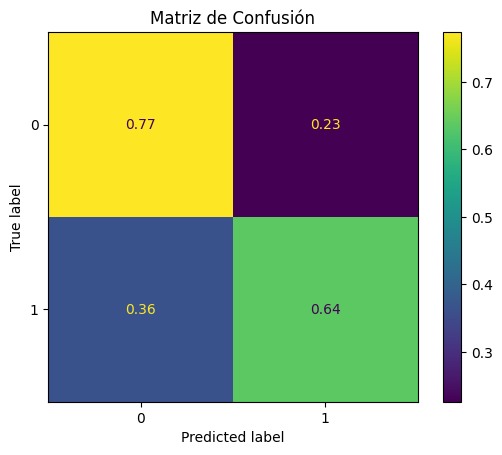

In [182]:
ConfusionMatrixDisplay.from_predictions(y_test_cat, modelo_pipeline_clf.predict(test), normalize = "true")
# ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
# Configuración del gráfico
plt.title("Matriz de Confusión")
plt.show()

#### 8. Conclusiones y acciones de mejora

Hemos conseguido aportar a Negocio como nos pedian una lista con 126 entidades que encajan en un perfil de nuestro cliente interesado por el medioambiente y con areas a mejorar. Es una lista mas manejable que los 1573 entidades que disponiamos.

Los resultado finales de la gestion de marketing será interesante para validar nuestra clusterizacion y tomar medidas de ajustes.

Acciones de mejora: Se recomienda unificar tipos de encuestas, restringir los campos como la actividad, año de creacción, numero empleados, porque su gestión es compleja al dejar un amplio margen. 

Por otro lado hemos creado un modelo para otras empresas distinta de las 1573 del sello RSA aprovechando la clusterización. Es una herramienta mas para centrar esfuerzos en un tipo u otro de entidad, asi podemos facilmente con 4 variables como son el tipo organizacion, la clasificacion de su actividad, numero empleados y año creacion, podremos con una confianza del 64% clasificar dentro de nuestro grupo objetivo. 

Acciones mejora: Se recomiendo retroalimentar el modelo ya que no deja de ser un modelo entrenado con 1753 datos y dentro de un tipo de entidades interesadas en un sello de RSA.